# Homework 1: NLP Basics and NLP Pipelines (7 + 1 points)

**Welcome to homework 1!** 

The homework contains several tasks. You can find the amount of points you get for the correct solution in the task header. Maximum amount of points for each homework is 7 + 1 (bonus exercise). 
The **grading** for each task is the following: 
* correct answer - **full points** 
* insufficient solution or solution resulting in the incorrect output - **half points**
* no answer or completely wrong solution - **no points**

Even if you don't know how to solve the task, we encourage you to write down your thoughts and progress and try to address the issues that stop you from completing the task.

When working on the written tasks, try to make your answers short and accurate. Most of the times, it is possible to answer the question in 1-3 sentences.

When writing code, make it readable. Choose appropriate names for your variables (a = 'cat' - not good, word = 'cat' - good). Avoid constructing lines of code longer than 100 characters (79 characters is ideal). If needed, provide the commentaries for your code, however, a good code should be easily readable without them :)

Finally, all your answers should be written only by yourself. If you copy them from other sources it will be considered as an academic fraud. You can discuss the tasks with your classmates but each solution must be individual.



**Before sending your solution, do the Kernel -> Restart & Run All to ensure that all your code works.**

In [1]:
!pip install stanza 
import stanza
stanza.download(lang='en') # download appropriate language model for your chosen language

2021-02-20 15:46:51 INFO: Downloading default packages for language: en (English)...
2021-02-20 15:46:52 INFO: File exists: /Users/ava/stanza_resources/en/default.zip.
2021-02-20 15:46:57 INFO: Finished downloading models and saved to /Users/ava/stanza_resources.


In [1]:
import nltk
from nltk import word_tokenize, sent_tokenize, pos_tag
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords, wordnet

import spacy
import stanza

from tqdm.notebook import tqdm
import re
from collections import defaultdict, Counter

import matplotlib.pyplot as plt

## Task 1: Find the data (0.5 points)

Find large enough text data in English or any other language supported by spaCy and Stanza. If the resources for your language are very limited, you may use English or other language of your preference. 

**What is the language of your data?**

Answer: English 

**Where did you get the text data?**

Answer: Project Gutenberg

**What kind of texts is it? (books,magazines, news articles, etc.)**

Answer: Book 

**What style(s) of text does your data have? (user commetaries, scientific, neutral, etc)**

Answer: Neutral

**Was it easy to download the data? If no, describe what difficulties you had and how you resolved them.**

Answer: Yes




## Task 2: Tokenize and count statistics (1 points)

Using either NLTK or Spacy tools, tokenize your text data you found in the previous exercise. 

P.S. If you are using Spacy, don't forget to load an appropriate module for it. 

**Compute and output the following:**
* number of sentences
* number of tokens
* number of unique tokens (or types)
* average length of a sentence 
* average length of a token
* sentence length (tokens in a sentence) histogram (you can use matplotlib.pyplot for that) 
* token length (characters in a token) histogram (you can use matplotlib.pyplot for that) 

In [111]:
# Replace the path with the name of your data file
data_path = "romeo_and_juliet.txt"

raw_data = open(data_path, encoding='utf-8').read()

# Split the data into sentences and tokens

In [112]:
import numpy as np
import re

# Minimal Cleaning: Removing escape characters from file
data = " ".join([token for token in raw_data.split(" ") if not re.search('[\n\t]', token)])

nlp = spacy.load("en_core_web_sm")
doc = nlp(data)

num_sentences = sum([1 for s in doc.sents])
num_tokens = sum([1 for s in doc.sents for token in s])
unique_tokens = list(set([token.text for s in doc.sents for token in s]))
num_unique_tokens = len(unique_tokens)
avg_sentence_len = np.mean([len(s) for s in doc.sents])
avg_token_len = np.mean([len(token) for token in unique_tokens])

print("Number of sentences:", num_sentences)
print("Number of tokens:", num_tokens)
print("Number of unique tokens (or types):", num_unique_tokens)
print("Average sentence length:", avg_sentence_len)
print("Average token length:", avg_token_len)

Number of sentences: 3337
Number of tokens: 30049
Number of unique tokens (or types): 3736
Average sentence length: 9.004794725801618
Average token length: 6.20610278372591


Text(0.5, 1.0, 'Sentence Length Distribution')

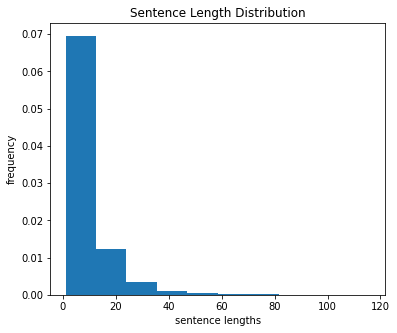

In [24]:
sentence_lengths = [len(s) for s in doc.sents] 

# draw the histogram 
plt.figure(figsize=(6,5))
plt.hist(sentence_lengths, density=True)
plt.xlabel('sentence lengths')
plt.ylabel('frequency')
plt.title('Sentence Length Distribution')

Text(0.5, 1.0, 'Token Length Distribution')

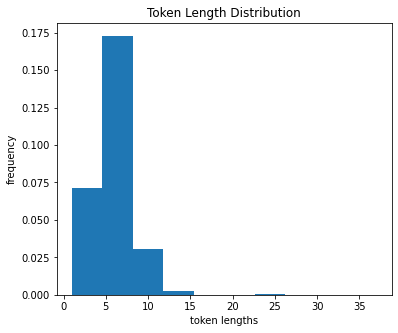

In [25]:
token_lengths = [len(token) for token in unique_tokens]

# draw the histogram
plt.figure(figsize=(6,5))
plt.hist(token_lengths, density=True)
plt.xlabel('token lengths')
plt.ylabel('frequency')
plt.title('Token Length Distribution')

## Task 3: Bype pair encoding (BPE) tokenization (1 point) 

### Task 3.1 (0.25 points)

Byte pair encoding (BPE) [link text](https://en.wikipedia.org/wiki/Byte_pair_encoding) is a simple algorithm of data compression. It looks for the most frequent pair of bytes in the data and replaces it with a new byte which is not seen in the data.

Recently, this idea became used in the [tokenization](https://www.aclweb.org/anthology/P16-1162.pdf). Let's say that we want to train a network that captures the meaning of words. We can have in out data the following words: low, lower, lowest. If we tokenize the text in a simple way by splitting the words as a whole, the model will probably learn the relation between low, lower, lowest. Now, imagine that we get some new text that the model didn't see during training and it has the words small, smaller, smallest and in the training data we had only the word small. Since the model didn't see smaller and smallest during the training, it will most likely fail to capture the relation.

One of the ways to solve this is BPE tokenization. It learns the most frequent sequences and can split an unknown word into **subwords**. In our case, it can split smaller into ['small', 'er'] since we had small in the training data and probably many other words ending with -er. Now. instead of one unknown word, the model have two known subwords from which it can take the information.

The code below builds the subwords from the text data. For the purpose of time saving, we set the number of merges to 1000.

**Study the code below and answer the questions after it.**


In [26]:
def get_vocab(filename):
    """Gets the text from a file and splits it with spaces."""
    
    vocab = Counter()
    with open(filename, encoding='utf-8') as f:
        for line in f:
            words = line.strip().split()
            for word in words:
                vocab[' '.join(list(word)) + ' </w>'] += 1
    return vocab

def get_stats(vocab):
    """Computes the frequencies for each pair of characters in the vocab."""

    pairs = Counter()
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i],symbols[i+1]] += freq
    return pairs

def merge_vocab(pair, in_vocab):
    """Merges the most frequent pair.

    Arguments:
    pair -- the most frequent word pair (tuple(str, str))
    in_vocab -- vocabulary with frequencies (dict)
    """
    
    out_vocab = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in in_vocab:
        out_word = p.sub(''.join(pair), word)
        out_vocab[out_word] = in_vocab[word]
    return out_vocab

def get_tokens_from_vocab(vocab):
    tokens_frequencies = Counter()
    vocab_tokenization = {}
    for word, freq in vocab.items():
        word_tokens = word.split()
        for token in word_tokens:
            tokens_frequencies[token] += freq
        vocab_tokenization[''.join(word_tokens)] = word_tokens
    return tokens_frequencies, vocab_tokenization

def measure_token_length(token):
    if token[-4:] == '</w>':
        return len(token[:-4]) + 1
    else:
        return len(token)

vocab = get_vocab(data_path)

print('==========')
print('Tokens Before BPE')
tokens_frequencies, vocab_tokenization = get_tokens_from_vocab(vocab)
print('All tokens: {}'.format(tokens_frequencies.keys()))
print('Number of tokens: {}'.format(len(tokens_frequencies.keys())))
print('==========')

num_merges = 1000
for i in tqdm(range(num_merges)):
    pairs = get_stats(vocab)
    if not pairs:
        break
    best = max(pairs, key=pairs.get)
    vocab = merge_vocab(best, vocab)

tokens_frequencies, vocab_tokenization = get_tokens_from_vocab(vocab)

print('All tokens: {}'.format(tokens_frequencies.keys()))
print('Number of tokens: {}'.format(len(tokens_frequencies.keys())))
print('==========')

Tokens Before BPE
All tokens: dict_keys(['1', '5', '9', '</w>', 'T', 'H', 'E', 'R', 'A', 'G', 'D', 'Y', 'O', 'F', 'M', 'N', 'J', 'U', 'L', 'I', 'b', 'y', 'W', 'i', 'l', 'a', 'm', 'S', 'h', 'k', 'e', 's', 'p', 'r', 't', 'P', 'o', 'n', 'C', 'u', '.', 'c', ',', 'f', 'V', 'g', 'd', 'w', 'v', 'B', "'", 'z', ';', '-', '[', 'x', ']', '(', ')', 'q', '?', '!', 'Q', 'j', ':', '2', '3', 'K', '"', 'Z'])
Number of tokens: 70



All tokens: dict_keys(['1', '5', '9', '</w>', 'T', 'H', 'E', 'R', 'A', 'G', 'D', 'Y', 'O', 'F', 'M', 'O</w>', 'N', 'J', 'U', 'L', 'I', 'by</w>', 'Wi', 'll', 'i', 'am</w>', 'Sha', 'k', 'es', 'p', 'ear', 'e</w>', 'ra', 'mat', 'is</w>', 'P', 'er', 'son', 'a', 'C', 'h', 'or', 'u', 's.</w>', 'sc', 'al', 's,</w>', 'Prin', 'ce</w>', 'of</w>', 'Verona', '.</w>', 'Paris', ',</w>', 'a</w>', 'young</w>', 'Coun', 't,</w>', 'kins', 'man</w>', 'to</w>', 'the</w>', 'Prince.</w>', 'Montague,</w>', 'hea', 'ds</w>', 'two</w>', 'hou', 'ses</w>', 'at</w>', 'v', 'ar', 'an', 'with</w>', 'ea', 'ch</w>', 'other.</w>', 'Capulet,</w>', 'An</w>', 'old</w>', 'Capul', 'et</w>', 'fa', 'm', 'il', 'y.</w>', 'Romeo,</w>', 'son</w>', 'Montagu', 'e.</w>', 'Tybalt,</w>', 'ne', 'he', 'w</w>', 'Lad', 'y</w>', 'et.</w>', 'Mercuti', 'o,</w>', 'and</w>', 'fri', 'end</w>', 'Romeo.</w>', 'Benvoli', 'Romeo</w>', 'Friar</w>', 'Laur', 'ence,</w>', 'ran', 'c', 'is', 'can', 'Jo', 'n,</w>', 'Bal', 'th', 'as', 'serv', 'ant</w>', 'bra

Answer the following questions: 

**Study the subwords from your data. Do you see any subwords that make sense from the linguistic point of view? (e.g suffixes, prefixes, common roots etc.). Provide examples.**

Answer: Yes there are many useful morphemes from the tokens generated from BPE. A variation of suffixes, common roots, prefixes, some examples include: -ation, -ings, -st, -est, happ-, distrib-, banish-

**What will happen if you increase the number of merges?**

Answer: More tokens are generated for higher merges, and most words are increasingly represented as their full forms. For eg. the morepheme distrib- from the previous question has more fuller forms as distribution and distributing for a higher number of merges.

### Task 3.2 (0.75 points) 
Now, you are going to implement the function that splits the unknown word into subwords using the vocab that we built above.

One way to do it is the following:

1. Sort our vocab by the length in the descending order.
2. Find the boundaries of the "window" that is going to search if a candidate word has a corresponding subword in the vocab. In the beginning, the starting index is 0, since we start to scan the word from the first characher. The end index is the length of the longest subword in the vocab or the length of the word if it is smaller.
3. In a while loop, start looking at the possible subwords. If the subword you are looking at is in the vocab, append it to the result. Now, your new starting index is your previous end index. Your new end index is your new start index plus the length of the longest subword in the vocab or the length of the word if it is smaller than the resulting sum. If the subword is not in the vocab, we reduce the end index by one thus narrowing our search window. Finally, is the length of our window is equal to one, we put an unknown subword in the result and update our window as above.
4. End the loop when we reach the end of the word.

After you finish with the function, test the tokenizer on a very common word and on a very unusual word (you can even try to invent a word yourself).


In [27]:
# Sorting the subwords by the length in the descending order
sorted_tokens_tuple = sorted(tokens_frequencies.items(), key=lambda item: (measure_token_length(item[0]), item[1]), reverse=True)
sorted_tokens = [token for (token, freq) in sorted_tokens_tuple]

def tokenize_word(string, sorted_tokens, unknown_token='</u>'):
    """
    Tokenizes the word into subword using learned BPE vocab
    
    Arguments:
    string -- a word to tokenize. Must end with </w>
    sorted_tokens -- sorted vocab by frequency in descending order
    unknown_token -- a token to replace the words not found in the vocab
    """
    
    if string == '':
        return []
    if sorted_tokens == []:
        return [unknown_token]

    # We are going to store our subwords here
    string_tokens = []
    
    # Find the maximum length of the ngram in vocab
    ngram_max_len = max([measure_token_length(t) for t in sorted_tokens])
    # End index is the maximum length of the ngram or the length of the string if it's smaller
    end_idx = ngram_max_len if len(string) > ngram_max_len else len(string)
    # Starting index is 0 in the beginning
    start_idx = 0
    
    while start_idx < len(string):
        subword = string[start_idx:end_idx]
        if subword in sorted_tokens:
            string_tokens.append(subword)
            start_idx = end_idx
            t_end_idx = start_idx + ngram_max_len
            end_idx = t_end_idx if len(string) > t_end_idx else len(string)
        elif len(subword) == 1:
            string_tokens.append(unknown_token)
        else:
            end_idx -= 1
            
    return string_tokens

# The word should end with "</w>". For example, "cat</w>".
word_known = 'father</w>'
word_unknown = 'vinimosity</w>'

print('Tokenizing word: {}...'.format(word_known))
if word_known in vocab_tokenization:
    print(vocab_tokenization[word_known])
else:
    print(tokenize_word(string=word_known, sorted_tokens=sorted_tokens, unknown_token='</u>'))
    

print('Tokenizing word: {}...'.format(word_unknown))
if word_unknown in vocab_tokenization:
    print(vocab_tokenization[word_unknown])
else:
    print(tokenize_word(string=word_unknown, sorted_tokens=sorted_tokens, unknown_token='</u>'))

Tokenizing word: father</w>...
['fa', 'ther</w>']
Tokenizing word: vinimosity</w>...
['vi', 'ni', 'mo', 'si', 'ty</w>']


## Task 4: Lemmatization and normalization (1 point) 

### Task 4.1 (0.5 points) 

Using either NTLK or Spacy, lemmatize your data. Make a copy of your data but this time transform all the tokens and lemmas into the lowercase.

Provide the following statistics:

* Number of unique lemmas (original case)
* Number of unique lemmas (lower case)
* Number of unique tokens (original case)
* Number of unique tokens (lower case)

In [35]:
# Lemmatize your data
lemma_ls = [token.lemma_ for token in doc]

# Make a copy of your tokens but in lowercase
tokens_ls = [token.text.lower() for token in doc]


# Count statistics (no need to calculate the number of unique tokens in original case since we did it in Task 2)
num_unique_lemmas = len(set(lemma_ls))
num_unique_lemmas_lower = len(set([lemma.lower() for lemma in lemma_ls]))
num_unique_tokens_lower = len(set(tokens_ls))

# Print out the numbers
print("Number of unique lemmas (original case):", num_unique_lemmas)
print("Number of unique lemmas (lower case):", num_unique_lemmas_lower)
print("Number of unique tokens (original case):", num_unique_tokens)
print("Number of unique tokens (lower case):", num_unique_tokens_lower)

Number of unique lemmas (original case): 3428
Number of unique lemmas (lower case): 3259
Number of unique tokens (original case): 4260
Number of unique tokens (lower case): 3811


### Task 4.2 (0.5 points)

Look at the numbers you got. 

**Imagine that you want to use your data to train a network that captures the meaning of the words. Do you want to use tokens or lemmas? Original or lowercase? Explain your choices.**

Answer: Lemmas in lowercase will be more appropriate in this case. The morphological parsing involved in lemmatization ensures that words are resolved to a root form, where static meaning is shared, irrespective of the case. And as seen with the counting results above, this leaves less tokens to process, making it an efficient approach.

**Imagine that you want to use your data to train a system that detects named entities, i.e. names of people, places, companies etc. Do you want to use tokens or lemmas? Original or lowercase? Explain your choice.**

Answer: I will go for tokens in their original form. Given that NER models use trained sequence labelers to estimate probability of entities in each sentence, firstly, reducing words to their root forms will unduly bias this probability distribution, also possibly accidentally giving named entities a shared root form with random words in certain cases. Secondly, it is important to leave tokens in their original case because a named entity is usually a noun and likely to be represented in as proper name, with first uppercase letter, making it easily identifiable.

## Task 5: Different Pipelines (0.5 points) 

In the next tasks you need to process your data from task 1 with two different pipelines. Use Stanza and spiCy for that. 

**What components do the pipelines have?**

Answer: 

**Spacy —** Tokenizer, Tagger (for POS), DependencyParser, NER, Entity Linker, Entity Ruler, Lemmatizer, TextCategorizer, Morphologizer, Attribute Ruler, Sentence Recognizer, Sentencizer (for sentence-based segmentation), Tok2Vec, Transformer, (custom components)

**Stanza —** Tokenizer/Multi-word Tokenizer, POS processor, Lemma processor, NER processor, Depparse processor (syntactic dependency parsing)

**What languages do the pipelines support?**

Answer: 

**Spacy —** Chinese, Danish, Dutch, English, French, German, Greek, Italian, Japanese, Lithuanian, Macedonian, Norwegian Bokmål, Polish, Portuguese, Romanian, Russian, Spanish

**Stanza —** Afrikaans, Ancient Greek, Arabic, Armenian, Basque, Belarusian, Bulgarian, Buryat, Catalan, Chinese (simplified), Chinese (traditional), Classical Chinese, Coptic, Croatian, Czech, Danish, Dutch, English,
Estonian, Finnish, French, Galician, German, Gothic, Greek, Hebrew, Hindi, Hungarian, Indonesian, Irish, Italian, Japanese, Kazakh, Korean, Kurmanji, Latin, Latvian, Lithuanian, Livvi, Maltese, Marathi, North Sami, Norwegian (Bokmaal), Norwegian (Nynorsk), Old Church Slavonic, Old French, Old Russian, Persian, Polish, Portuguese,
Romanian, Russian, Scottish Gaelic, Serbian, Slovak, Slovenian, Spanish, Swedish, Swedish Sign Language, Tamil, Telugu, Turkish, Ukrainian, Upper Sorbian, Urdu, Uyghur, Vietnamese, Wolof


## Task 6: Process your text (2 points) 

### Task 6.1 (1.5 point) 

Process the text data from the first task with two different pipelines. Use Stanza and spiCy for that. 

Select one sentence from the processed document and print out all the results (tokens, pos-tags, lemmas, depparse, etc.) from both pipelines. 

In [107]:
# Process the text 
# Pipeline 1
stanza_nlp = stanza.Pipeline("en")
stanza_doc = stanza_nlp(data)

# Pipeline 2
spacy_nlp = spacy.load("en_core_web_sm")
spacy_doc = spacy_nlp(data)

# Print out the results from both pipelines
print("Stanza Pipeline: \n")
idx = 0
for sentence in stanza_doc.sentences:
    if idx == 69:
        print(*[f'word: {word.text}\t\tlemma: {word.lemma} \t\tPOS: {word.upos}\t\thead: \
        {sentence.words[word.head-1].text if word.head > 0 else "root"}\t\tdeprel: {word.deprel}' for word in sentence.words], sep='\n')
    idx += 1
    
print("\n\nSpacy Pipeline:\n")
sp_sentences = list(spacy_doc.sents)
for token in sp_sentences[74]:
    print(*[f'word: {token.text}\t\tlemma: {token.lemma_} \t\tPOS: {token.pos_}\t\thead: {token.head.text} \t\tdeprel: {token.dep_}'], sep='\n')


Stanza Pipeline: 

word: Take		lemma: take 		POS: VERB		head:         root		deprel: root
word: it		lemma: it 		POS: PRON		head:         Take		deprel: obj
word: in		lemma: in 		POS: ADP		head:         sense		deprel: case
word: what		lemma: what 		POS: DET		head:         sense		deprel: det
word: sense		lemma: sense 		POS: NOUN		head:         Take		deprel: obl
word: thou		lemma: thou 		POS: PRON		head:         wilt		deprel: nsubj
word: wilt		lemma: will 		POS: AUX		head:         sense		deprel: acl:relcl
word: .		lemma: . 		POS: PUNCT		head:         Take		deprel: punct


Spacy Pipeline:

word: Take		lemma: take 		POS: VERB		head: Take 		deprel: ROOT
word: it		lemma: -PRON- 		POS: PRON		head: Take 		deprel: dobj
word: in		lemma: in 		POS: ADP		head: Take 		deprel: prep
word: what		lemma: what 		POS: DET		head: sense 		deprel: det
word: sense		lemma: sense 		POS: NOUN		head: in 		deprel: pcomp
word: thou		lemma: thou 		POS: NOUN		head: wilt 		deprel: compound
word: wilt		lemma: wilt 		POS: N

### Task 6.2 (0.5 points)

**Look at the output from both pipelines. Are the results correct and do the pipelines have the same output? If no, provide the examples of the mistakes and differences.** 

Answer: The outputs are very similar, and the nuances regarding the dependency parsing are explained below. However Spacy gets a few things wrong with the POS and lemma. It is unable to get the lemma for 'it', replacing it with -PRON-, a thing it does typically with pronounces, and also is unable to reduce 'wilt' to its known root form 'will' like Stanza did. Also it misclassifies 'thou' and 'wilt' as nouns. Stanza identifies them correctly as PRONOUN and AUXILIARY verb respectively.

**What is the difference between a POS tag and morphological tag?**

Answer: The POS tag labels more generic and core parts-of-speech categories, like nouns, verbs etc., whilst the morpholigical tags, looks into more detailed lexical and grammatical properties of the tokens, not covered by the core POS categories, with categories like Reflexiveness, Politeness, etc.

**What is the difference between tagging and parsing?**

Answer: Tagging involves assigning (usually) POS labels to tokens or words in texts, useful in analyzing texts, but parsing however involves extracting syntactic meaning from texts, for eg. by using these tags.

**Analyze the dependency parsing result from both pipelines. Does the results make sense? Briefly describe the meaning behind the relations.**

Answer: There are varying extensions of the dependency parser from both pipelines, but the minimal analyses done in the previous block mainly shows the syntactic relationship between a word (head) and it's child, i.e. the dependencies modeled between these pairs to create some meaning from the entire sentence. With some extra work understanding the label symbols, it is easy to understand the results of the dependency parsing.

The sentence analyzed is: 'Take it in what sense thou wilt.'

Both pipelines rightly consider 'Take' as the root of the sentence and 'it' as the (direct) object of this root. Spacy considers the next word 'in' as more related to the root, acting as a preposition as seen in the phrase 'Take in', whilst Stanza considers it related to 'sense', also as preposition (labeled 'case' however), as '..in sense'. Both takes are justified, in my opinion, as 'in' serves both words. Now we have: 'Take it in...'

Next, 'what' is correctly identified as a determiner to 'sense' in both pipelines, however 'sense' is identified in relation to 'Take' for Stanza and in relation to 'in' for Spacy; however, both capture the right relationship with different approaches. In Stanza the relation is 'Take...sense' , where 'sense' is an oblique nominal that  complements the case 'in' to highlight the relationship 'Take ... in sense'; pretty good capture of the relationship. This complementary relationship between an oblique nominal and case is explained in the Universal Dependencies documentation from Stanza. Spacy considers 'in...sense', where sense is a complement of the preposition 'in', which itself is a preposition of 'Take'.

Both, again consider 'thou' to be related to 'wilt', with Stanza labeling 'thou' in this case as a nominal subject of 'wilt', and Spacy, labeling them as a compound word. Different nuances here but right relationships captured; both ar equally correct.

For the last word pair, Stanza considers 'wilt' to be related more with 'sense', with the former serving as a relative clause modifier for the noun 'sense'. Spacy however considers 'wilt' to be an object of the preposition 'in'. Both explanations are not so clear, as especially with the latter, the sentence seems too far gone to have a late relationship between the end and an early word, in the context being analyzed. 

Lastly, both correctly identify the relationship between the fullstop and 'Take', which was the root in this case, with the period labeled as a punctuation and the last character of the sentence.


**Is one pipeline better than the other based on the output of one sentence?**

Answer: Based on the output of ONE sentence, I wouldn't think so. However, Spacy doesn't get it all right here especially with the mislabeling of POS and lemmatization, but some more intrinsic evaluation, generalizable on the corpus, will be needed to determine if Stanza is preferable in this case.

## Task 7: Statistics (1 point)

In your processed output (choose output from only one of the pipelines), compute and print out (in a human readable format) the following statistics: 
* POS tag frequency for each tag (in descending order) 

* 50 most frequent lemmas 
* 10 least frequent lemmas 

In [110]:
import collections
import itertools

POS_tags = list()
lemmas_tc = list()

for token in doc:
    POS_tags.append(token.pos_)
    
    # Excluding Spacy's generic -PRON-, non-words like numbers, and stopwords, to make it more interesting
    if token.lemma_ != "-PRON-" and re.search(r'\w+', token.lemma_) and token.lemma_ not in nlp.Defaults.stop_words:
        lemmas_tc.append(token.lemma_)
    

# Compute and print out POS tag frequency 
POS_Counter = collections.Counter(POS_tags)
print("POS TAG Frequency")
print(POS_Counter)


lemmas_Counter = collections.Counter(lemmas_tc)

# Compute and print out 50 most frequent lemmas 
print('\n 50 Most Frequent Lemmas')
print(lemmas_Counter.most_common(50))


# Compute and print out 10 least frequent lemmas 
print('\n 10 Least Frequent Lemmas')
print(lemmas_Counter.most_common()[:-11:-1])

POS TAG Frequency
Counter({'PUNCT': 6642, 'NOUN': 5540, 'VERB': 4948, 'DET': 3143, 'ADP': 2513, 'PRON': 2447, 'PROPN': 2015, 'ADV': 1818, 'ADJ': 1702, 'CCONJ': 1032, 'PART': 640, 'INTJ': 369, 'NUM': 157, 'SPACE': 36, 'X': 23})

 50 Most Frequent Lemmas
[('thou', 238), ('thy', 159), ('love', 151), ('o', 151), ('rom', 151), ('Romeo', 144), ('come', 137), ('thee', 135), ('July', 117), ('man', 101), ('Nurse', 98), ('shall', 94), ('night', 88), ('good', 86), ('enter', 77), ('Friar', 74), ('death', 71), ('Tybalt', 65), ('Juliet', 65), ('Ben', 64), ('day', 60), ('art', 54), ('let', 53), ('sir', 53), ('Cap', 53), ('hath', 53), ('lady', 50), ('tell', 48), ('nurse', 47), ('fair', 47), ('eye', 46), ('dead', 46), ('know', 45), ('Capulet', 44), ('like', 42), ('lie', 41), ('speak', 41), ('Prince', 40), ('Thou', 40), ('Mer', 40), ('look', 39), ('doth', 39), ('hand', 38), ('time', 38), ('sweet', 37), ('Paris', 35), ('wife', 35), ('word', 35), ('heart', 35), ('house', 34)]

 10 Least Frequent Lemmas
[(

## Bonus Task: WordCloud (1 point) 

Wordcloud gives us a visual representation of the most common words in the data. Visualisation is key to understanding whether we are on the right track with preprocessing, it allows us to verify if we need more preprocessing before further analysing the text data. 

**Your task is to create three wordclouds. One wordcloud should be created before any preprocessing is done to the text data and other two is created from the preprocessed text data. 
Do suitable preprocessing for tasks described in 4.2. This means:**
1. preprocess data, so we could train a neural network that will capture the meaning of words. 
2. preprocess data, so we could train a system that detects named entities.


Python has a massive number of open libraries for drawing wordclouds. You can use Andreas Mueller's [wordcloud](http://amueller.github.io/word_cloud/) library to do that.



(-0.5, 399.5, 199.5, -0.5)

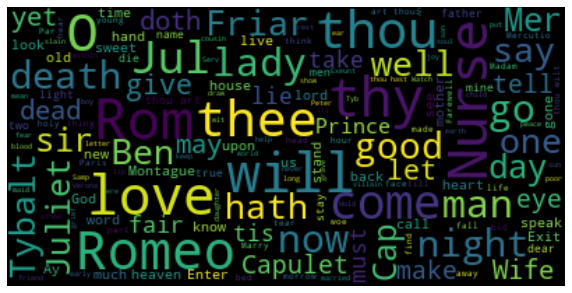

In [113]:
# !pip install wordcloud
from wordcloud import WordCloud

# create the first wordcloud from raw text data
wordcloud = WordCloud(max_font_size=40).generate(raw_data)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

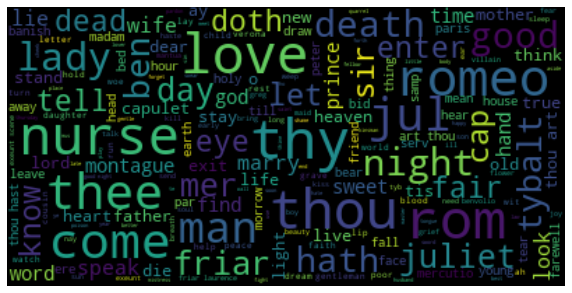

In [126]:
# Preprocess the data for task 1

lemma_wordcloud = " ".join([word.lemma.lower() for sentence in stanza_doc.sentences for word in sentence.words \
                           if word.lemma.lower() not in nlp.Defaults.stop_words])
wordcloud_2 = WordCloud(max_font_size=40).generate(lemma_wordcloud)

# create the second wordcloud
plt.figure(figsize=(10,12))
plt.imshow(wordcloud_2, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

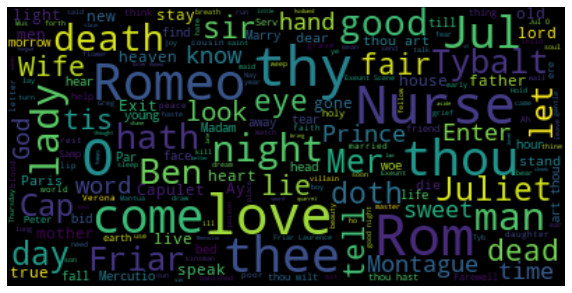

In [127]:
# Preprocess the data for task 2
tokens_wordcloud = " ".join([word.text for sentence in stanza_doc.sentences for word in sentence.words \
                           if word.text.lower() not in nlp.Defaults.stop_words])

wordcloud_3 = WordCloud(max_font_size=40).generate(tokens_wordcloud)

# create the third wordcloud
plt.figure(figsize=(10,12))
plt.imshow(wordcloud_3, interpolation='bilinear')
plt.axis("off")

**What are the differences between these wordclouds (provide examples)? Can you say from the wordclouds if the preprocessing was enough for the tasks?**

Answer:  Some stop words like 'upon', 'us', 'well', 'now', 'will', 'yet', 'may', that appear in the raw data cloud, were removed for the processed text. But apart from that most of the prominent words in the wordclouds look very similar, and even with respect to the raw data, which for one reason implies there was little noise in the original. The preprocessing appears satisfactory.